In [10]:
# Ensure the project root is in PATH.
import sys

# from backtester.backtester import Backtester
# from backtester.datamodel import TradingState, OrderDepth, Order, Listing
# from backtester.log import Log
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [11]:
# Black-Scholes call price function (assumes risk-free rate r=0)
def bs_call_price(S, K, T, sigma, r=0.0):
    """
    Returns the Black-Scholes call option price for underlying S, strike K,
    time to expiry T and volatility sigma.
    If T <= 0, returns the payoff.
    """
    if T <= 0:
        return max(0.0, S - K)
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

# Implied volatility function via Brent's method
def implied_volatility(S, K, T, market_price, r=0.0, tol=1e-6, max_iter=100):
    """
    Solves for the implied volatility such that the Black-Scholes price equals market_price.
    If a solution is not found, returns np.nan.
    """
    def objective(sigma):
        return bs_call_price(S, K, T, sigma, r) - market_price
    try:
        iv = brentq(objective, 1e-6, 5.0, xtol=tol, maxiter=max_iter)
    except Exception as e:
        iv = np.nan
    return iv


In [14]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("/Users/mlee/Desktop/Coding Workspace/imc/prosperity-crushers", "data", "round3", "trades_round_3_day_2.csv"), sep=";")

market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

underlying = market_data_round_3_all3days[ market_data_round_3_all3days['product'] == "VOLCANIC_ROCK" ]
vouchers = market_data_round_3_all3days[ market_data_round_3_all3days['product'].str.contains("VOLCANIC_ROCK_VOUCHER") ].copy()

print("Underlying data sample:")
print(underlying.head())
print("\nVoucher data sample:")
print(vouchers.head())

Underlying data sample:
    day  timestamp        product  bid_price_1  bid_volume_1  bid_price_2  \
13    0          0  VOLCANIC_ROCK      10502.0         205.0          NaN   
21    0        100  VOLCANIC_ROCK      10509.0         192.0          NaN   
31    0        200  VOLCANIC_ROCK      10512.0         167.0          NaN   
55    0        300  VOLCANIC_ROCK      10517.0         118.0      10516.0   
60    0        400  VOLCANIC_ROCK      10509.0         128.0      10508.0   

    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
13           NaN          NaN           NaN        10504           146   
21           NaN          NaN           NaN        10511           122   
31           NaN          NaN           NaN        10514           109   
55          68.0          NaN           NaN        10518           118   
60          73.0          NaN           NaN        10510           128   

    ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price 

In [15]:
# Convert the day column to a numeric value (if needed) and compute TTE.
vouchers['day'] = pd.to_numeric(vouchers['day'], errors='coerce')
# Assuming "day" here corresponds to the round number, then:
vouchers['TTE'] = 7 - (vouchers['day'] - 1)  # For round 3 this yields 5.

# Extract the strike price from the product name.
# Expecting product format: "VOLCANIC_ROCK_VOUCHER_XXXX" where XXXX is the strike.
vouchers['strike'] = vouchers['product'].str.extract(r'VOLCANIC_ROCK_VOUCHER_(\d+)', expand=False).astype(float)

# Now, merge voucher data with the underlying price.
# First, sort both dataframes by timestamp.
vouchers = vouchers.sort_values('timestamp')
underlying = underlying.sort_values('timestamp')

# Use merge_asof to attach the most recent underlying mid_price to each voucher record.
merged = pd.merge_asof(vouchers, 
                       underlying[['timestamp', 'mid_price']], 
                       on='timestamp', 
                       suffixes=("", "_underlying"))

# Rename columns for clarity.
# Let's assume: S_t = underlying mid_price, V_t = voucher mid_price.
merged = merged.rename(columns={'mid_price': 'V_t', 'mid_price_underlying': 'S_t'})

# Check the merged data
print("Merged Data Sample:")
print(merged[['timestamp', 'product', 'strike', 'TTE', 'S_t', 'V_t']].head())


Merged Data Sample:
   timestamp                      product   strike  TTE      S_t     V_t
0          0  VOLCANIC_ROCK_VOUCHER_10500  10500.0    8  10503.0    99.5
1          0  VOLCANIC_ROCK_VOUCHER_10000  10000.0    8  10503.0   505.5
2          0   VOLCANIC_ROCK_VOUCHER_9750   9750.0    8  10503.0   754.5
3          0   VOLCANIC_ROCK_VOUCHER_9500   9500.0    8  10503.0  1003.5
4          0  VOLCANIC_ROCK_VOUCHER_10250  10250.0    8  10503.0   273.5


In [16]:
# Compute m_t: note that we use the natural logarithm.
merged['m_t'] = np.log(merged['strike'] / merged['S_t']) / np.sqrt(merged['TTE'])

# Compute v_t using our implied volatility function.
# We assume V_t is the observed voucher price.
merged['v_t'] = merged.apply(lambda row: implied_volatility(row['S_t'], row['strike'], row['TTE'], row['V_t']), axis=1)

# Inspect the computed columns.
print("After computing m_t and v_t:")
print(merged[['timestamp', 'product', 'strike', 'TTE', 'S_t', 'V_t', 'm_t', 'v_t']].head())


After computing m_t and v_t:
   timestamp                      product   strike  TTE      S_t     V_t  \
0          0  VOLCANIC_ROCK_VOUCHER_10500  10500.0    8  10503.0    99.5   
1          0  VOLCANIC_ROCK_VOUCHER_10000  10000.0    8  10503.0   505.5   
2          0   VOLCANIC_ROCK_VOUCHER_9750   9750.0    8  10503.0   754.5   
3          0   VOLCANIC_ROCK_VOUCHER_9500   9500.0    8  10503.0  1003.5   
4          0  VOLCANIC_ROCK_VOUCHER_10250  10250.0    8  10503.0   273.5   

        m_t       v_t  
0 -0.000101  0.008270  
1 -0.017351  0.008897  
2 -0.026302  0.011780  
3 -0.035486  0.013473  
4 -0.008621  0.008539  


In [20]:
# Set your desired bucket size (e.g., 500)
bucket_size = 500

# Create a new column "time_bucket" (do not convert timestamp to datetime, treat as integer multiples)
merged['time_bucket'] = (merged['timestamp'] // bucket_size) * bucket_size

# Dictionary to store fitted quadratic parameters per time bucket
fitted_bucket_params = {}

# Group the merged data by time_bucket
bucket_groups = merged.groupby('time_bucket')

for bucket, group in bucket_groups:
    m_vals = group['m_t'].values
    v_vals = group['v_t'].values
    
    # Remove any NaNs from the calculations.
    valid = ~np.isnan(m_vals) & ~np.isnan(v_vals)
    m_vals = m_vals[valid]
    v_vals = v_vals[valid]
    
    # Require at least three points to fit a quadratic curve.
    if len(m_vals) < 3:
        continue
    
    # Fit a quadratic curve: v_t = a*m_t^2 + b*m_t + c
    coeffs = np.polyfit(m_vals, v_vals, 2)  # coeffs: [a, b, c]
    fitted_bucket_params[bucket] = coeffs
    
    # # Optionally, plot the raw data and the fitted quadratic for this time bucket.
    # plt.figure(figsize=(8, 6))
    # plt.scatter(m_vals, v_vals, label="Data", color='blue')
    # m_fit = np.linspace(min(m_vals), max(m_vals), 100)
    # v_fit = np.polyval(coeffs, m_fit)
    # plt.plot(m_fit, v_fit, 'r-', label="Fitted Quadratic")
    # plt.xlabel(r"$m_t = \log(K/S_t)/\sqrt{\text{TTE}}$")
    # plt.ylabel(r"$v_t$ (Implied Vol)")
    # plt.title(f"Quadratic Fit for Time Bucket {bucket}")
    # plt.legend()
    # plt.grid(True)
    # plt.show()


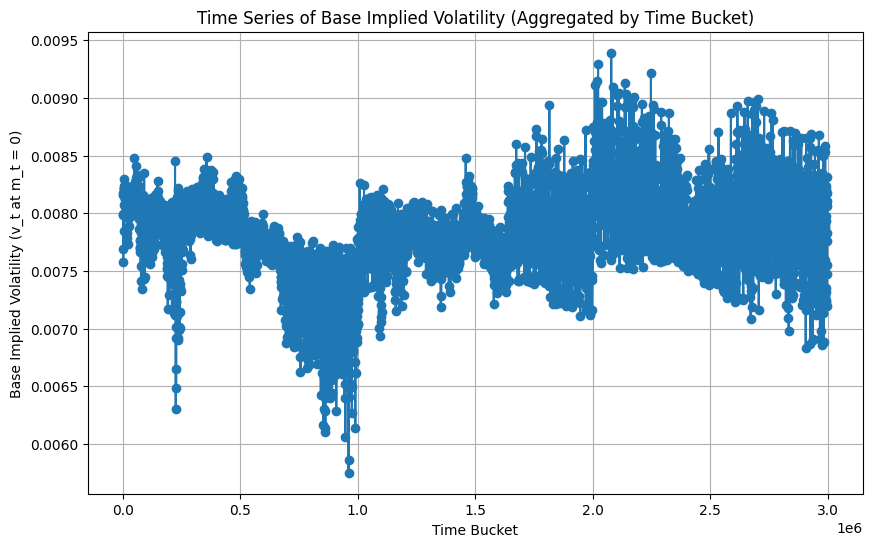

In [21]:
# Extract base IV for each time bucket (the intercept 'c' from the quadratic fit).
base_iv_bucket = {bucket: coeffs[2] for bucket, coeffs in fitted_bucket_params.items()}
base_iv_bucket_series = pd.Series(base_iv_bucket).sort_index()

# Plot the time series of base IV aggregated by time bucket.
plt.figure(figsize=(10, 6))
plt.plot(base_iv_bucket_series.index, base_iv_bucket_series.values, marker='o', linestyle='-')
plt.xlabel("Time Bucket")
plt.ylabel("Base Implied Volatility (v_t at m_t = 0)")
plt.title("Time Series of Base Implied Volatility (Aggregated by Time Bucket)")
plt.grid(True)
plt.show()
